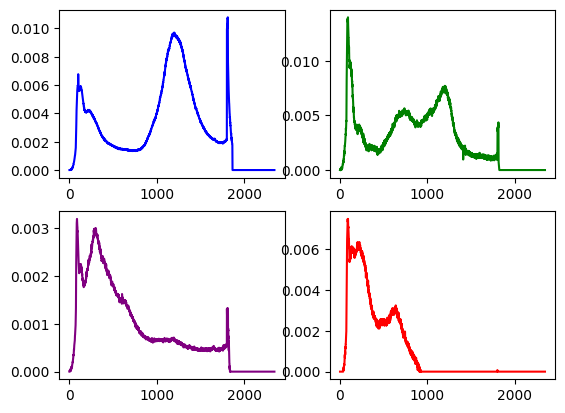

In [98]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pybeads
import os

# CSVファイルを読み込み
file_path = '/workspaces/Modulus/DESK/Peak_analysis/TM300-HT_1800-GMS.csv'
data = pd.read_csv(file_path, engine='python')

# Figureオブジェクトを作成
fig = plt.figure()
# Axesオブジェクトを作成
# 1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# プロットするデータ
x = data['Temp.']
H2 = data['H2']
CO = data['CO']
CO2 = data['CO2']
H2O = data['H2O']

# プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

# プロットの表示
plt.show()

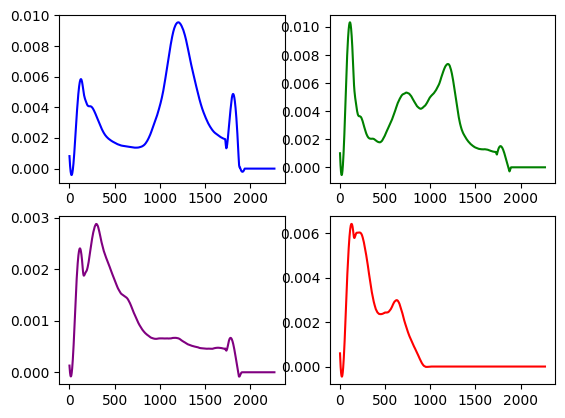

In [99]:
# H2, CO, CO2, H2Oシグナルを平滑化（Savitzky-Golayフィルタ使用）

smoothed_data = {
    'H2': savgol_filter(data['H2'], window_length=151, polyorder=3),
    'H2O': savgol_filter(data['H2O'], window_length=151, polyorder=3),
    'CO': savgol_filter(data['CO'], window_length=151, polyorder=3),
    'CO2': savgol_filter(data['CO2'], window_length=151, polyorder=3)
}
#Figureオブジェクトを作成
fig = plt.figure()
#Axesオブジェクトを作成
#1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#プロットするデータ
x = data['Temp.']
H2 = smoothed_data['H2']
CO = smoothed_data['CO']
CO2 = smoothed_data['CO2']
H2O = smoothed_data['H2O']

#プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

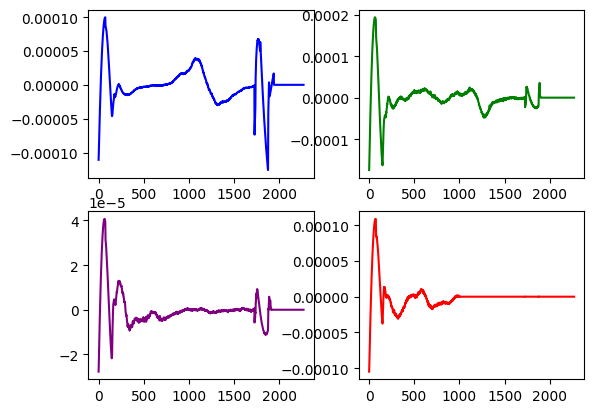

In [100]:
# 各ガスシグナルの微分を計算
derivatives = {
    'H2': np.gradient(smoothed_data['H2'], data['Temp.']),
    'H2O': np.gradient(smoothed_data['H2O'], data['Temp.']),
    'CO': np.gradient(smoothed_data['CO'], data['Temp.']),
    'CO2': np.gradient(smoothed_data['CO2'], data['Temp.'])
}

#Figureオブジェクトを作成
fig = plt.figure()
#Axesオブジェクトを作成
#1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#プロットするデータ
x = data['Temp.']
H2 = derivatives['H2']
CO = derivatives['CO']
CO2 = derivatives['CO2']
H2O = derivatives['H2O']

#プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

# ゼロ交差点を格納する辞書
zero_crossing_indices = {}

# 各ガスについてループを回して、微分が0に近い箇所を探す
for gas in ['H2', 'H2O', 'CO', 'CO2']:
    zero_crossing_indices[gas] = np.where(np.abs(derivatives[gas]) < 0.6)[0]


In [101]:
# ピーク特性を格納する辞書を作成
peak_properties = {}

for gas in ['H2', 'CO', 'CO2', 'H2O']:
    signal = smoothed_data[gas]
    temperature = data['Temp.']

    # ゼロ交差点の中で最大のy値を持つインデックスを特定
    peak_index = np.argmax(signal[zero_crossing_indices[gas]])
    peak_temperature = zero_crossing_indices[gas][peak_index]
    peak_intensity = signal[peak_temperature]
    
    # 半値を計算し、FWHMの両端を探す
    half_max = peak_intensity / 2
    left_idx = np.where(signal[:peak_temperature] < half_max)[0]
    right_idx = np.where(signal[peak_temperature:] < half_max)[0]

    # FWHMに基づいた開始温度と終了温度の特定
    start_temp = temperature[left_idx[-1]] if left_idx.size > 0 else temperature[0]
    end_temp = temperature[peak_temperature + right_idx[0]] if right_idx.size > 0 else temperature[-1]

    # 対称性の計算
    symmetry = ((peak_temperature - start_temp) - (end_temp - peak_temperature))
    
    # 特性を辞書に格納
    peak_properties[gas] = {
        "Peak Temperature": peak_temperature,
        "Peak Intensity": peak_intensity,
        "FWHM": end_temp - start_temp,
        "Start Temperature": start_temp,
        "End Temperature": end_temp,
        "Symmetry": symmetry
    }

# 結果を表示
peak_properties_df = pd.DataFrame(peak_properties).T
print(peak_properties_df)
peak_properties_df.to_csv(f'{os.path.splitext(os.path.basename(file_path))[0]}peak_properties.csv')



     Peak Temperature  Peak Intensity   FWHM  Start Temperature  \
H2             1205.0        0.009554  401.0             1028.0   
CO              109.0        0.010330  101.0               64.0   
CO2             297.0        0.002880  568.0               70.0   
H2O             127.0        0.006410  289.0               71.0   

     End Temperature  Symmetry  
H2            1429.0     -47.0  
CO             165.0     -11.0  
CO2            638.0    -114.0  
H2O            360.0    -177.0  


ベースライン除去

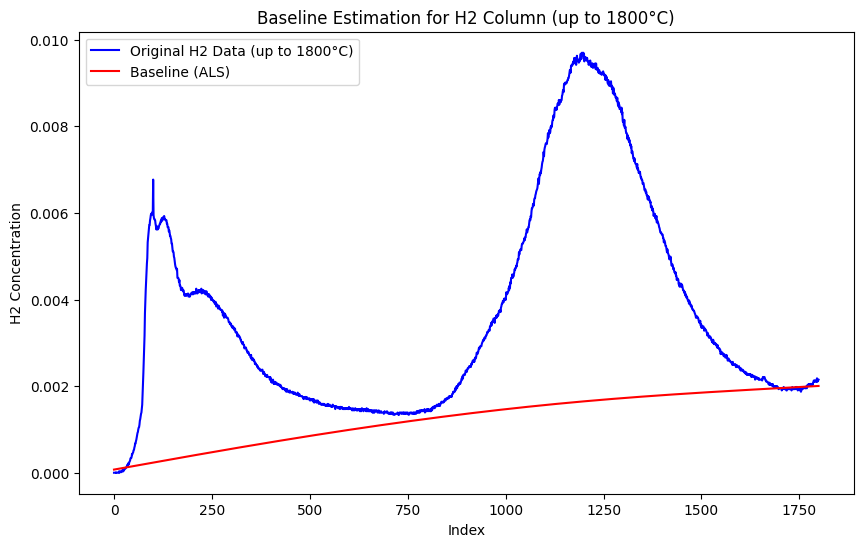

In [102]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, spdiags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Baseline ALS function
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

# Filter data up to 1800 degrees in the 'Temp.' column
filtered_data = data[data['Temp.'] <= 1800]
h2_filtered = filtered_data['H2'].values

# Apply the baseline ALS on the filtered H2 data
baseline_h2_filtered = baseline_als(h2_filtered, lam=1e9, p=0.001)

# Plot the filtered original data and the estimated baseline
plt.figure(figsize=(10, 6))
plt.plot(h2_filtered, label='Original H2 Data (up to 1800°C)', color='blue')
plt.plot(baseline_h2_filtered, label='Baseline (ALS)', color='red')
plt.xlabel('Index')
plt.ylabel('H2 Concentration')
plt.title('Baseline Estimation for H2 Column (up to 1800°C)')
plt.legend()
plt.show()
